# Final work, from "SpatialDE: identification of spatially variable genes"

The code for processing the data is taken from the git repository: https://github.com/Teichlab/SpatialDE made by the authors. I took the processing part added some comments

**SpatialDE** is a method to identify genes which significantly depend on spatial coordinates in non-linear and non-parametric ways. The intended applications are spatially resolved RNA-sequencing from e.g. Spatial Transcriptomics, or _in situ_ gene expression measurements from e.g. SeqFISH or MERFISH. We use SeqFISH DATA in our case.

Additionally, SpatialDE provides **automatic expression histology**, a method that groups genes into common spatial patterns (and conversely reveal histological patterns based on gene coexpression).


The primary implementation is as a Python 3 package, and can be installed from the command line by 

```
$ pip install spatialde
```

In the first part I try to make the figure 2h of the paper, to first find genes that are spatially relevant and to try to find patterns by combining genes. In the second part, I try to recover the spatial information by only taking the "spatial gene".

## I SpatialDE for tumour seqfish data 

We want to reproduce the figure 2h from the article. We will thus use the **automatic expression histology** given by **SpatialDE**

### 1) Import the data and visualization

In [7]:
%pylab inline
import pandas as pd
import numpy as np

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

Populating the interactive namespace from numpy and matplotlib


In [32]:
sample_info = pd.read_csv('sample_info_43.csv', index_col=0) #spatial coordinates of the cell

print(sample_info.shape)
sample_info.iloc[:7, :5]

(257, 5)


,x,y,z,field,total_count
1382,686,352,1,43,3408
1383,488,572,1,43,2191
1384,178,624,1,43,2626
1385,614,698,1,43,3015
1386,516,726,1,43,3488
1387,293,96,2,43,2468
1388,384,154,2,43,1693


In [316]:
df = pd.read_csv('exp_mat_43.csv', index_col=0) #gene expression for each cell for each gene
df.columns = df.columns.map(int)

df = df[sample_info.index]

print(df.shape)
df.iloc[:7, :7]

(249, 257)


,1382,1383,1384,1385,1386,1387,1388
0,,,,,,,
'Tal1',3,3,12,17,20,4,13
'Dmbx1',11,9,3,1,4,11,0
'Emx2',13,14,1,2,9,14,2
'Uncx',5,21,0,3,5,4,14
'Paxip1',15,9,8,10,13,3,9
'Ctnnb1',51,20,33,58,67,45,18
'Prdm1',20,9,13,3,17,4,3


We can plot the x and y coordinates in the sample info table to see which locations of the tissue slice has been sampled.

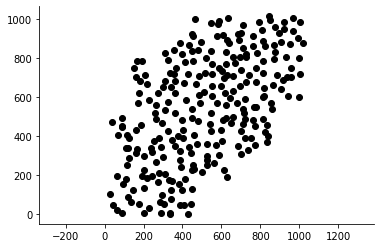

In [33]:
figsize(6, 4)
plt.scatter(sample_info['x'], sample_info['y'], c='k');
plt.axis('equal');

### 2) Data preprocessing

The method assumes normally distributed noise, but the data we are using is from expression counts, and empirically seems to follow a negative binomial distribution. We use technique by Anscombe to approximately transform the data to normal distributed noise.

Secondly, library size or sequencing depth of the spatial samples will bias the expression of every gene. We use linear regression to account for this effect before performing the spatial test.

In [341]:
dfm = NaiveDE.stabilize(df.T).T
res = NaiveDE.regress_out(sample_info, dfm, 'np.log(total_count)').T

res

0,'Tal1','Dmbx1','Emx2','Uncx','Paxip1','Ctnnb1','Prdm1','Rybp','Nfkb2','Tfdp2',...,'acta2','alldh1l1','camk2','chat','cldn5','ngef','tiam1','slc1a2','gja1','fbll1'
1382,-6.334421,-3.384267,-5.861625,-6.514957,-6.818802,-4.308174,-4.264909,-6.143242,-4.216714,-4.837799,...,-2.388779,-6.189076,-4.900730,-4.299373,-2.976802,-5.100197,-5.277472,-3.972963,-0.141299,-2.836500
1383,-5.909876,-3.239545,-5.331269,-4.807869,-6.751883,-4.754595,-4.588311,-7.131630,-4.420035,-5.678764,...,-2.036260,-6.154594,-4.570698,-4.228442,-2.927538,-4.883848,-5.731422,-3.769056,0.371325,-2.816372
1384,-4.970765,-4.230736,-7.378929,-7.764686,-7.067056,-4.464057,-4.426146,-6.688162,-3.655322,-4.987590,...,-2.352845,-5.940409,-5.352747,-4.214431,-2.537069,-5.290734,-5.096640,-3.703796,0.659482,-2.744865
1385,-4.786487,-4.936495,-7.175870,-6.763311,-7.037527,-4.058261,-5.735716,-6.304019,-3.296949,-4.442616,...,-1.213588,-6.200714,-4.465940,-4.236309,-2.892863,-5.179549,-5.239812,-4.056334,-0.548724,-2.850458
1386,-4.775519,-4.232062,-6.211291,-6.538839,-6.976259,-4.065306,-4.436830,-6.169226,-3.165529,-4.578284,...,-1.627347,-6.481534,-4.668012,-4.110432,-2.314708,-5.121689,-4.945742,-3.745688,-0.274474,-2.757083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,-5.313805,-3.157500,-5.296648,-7.159082,-6.016983,-4.886214,-6.224678,-7.819079,-4.096671,-5.557200,...,-3.807757,-6.599779,-4.338546,-4.465715,-2.556733,-5.870824,-5.548421,-4.698614,-1.694182,-3.134679
1635,-4.964232,-4.075479,-5.985018,-7.834756,-5.850446,-4.624491,-4.812819,-6.550899,-4.063814,-4.480559,...,-2.833213,-5.880671,-4.508318,-4.172890,-3.006466,-5.227093,-5.318215,-4.550667,-1.877384,-2.961185
1636,-4.951170,-3.030830,-6.547370,-5.953871,-5.775353,-4.122794,-5.850499,-5.996468,-4.232713,-4.345286,...,-2.341239,-5.518360,-4.546555,-4.311022,-2.861799,-4.931649,-5.404471,-4.331975,-1.852695,-3.335312
1637,-5.439077,-3.139652,-6.293111,-5.390982,-7.889770,-4.301785,-4.678995,-5.708347,-5.010343,-5.046480,...,-2.092126,-6.433143,-4.688357,-4.116835,-2.412480,-5.991566,-4.887966,-4.238823,-0.587007,-2.933642


### 3) Spatial test

Now we do the spatial test. It consists in determining what proportion of gene expression can be explained by its position.

In [10]:
import NaiveDE

In [13]:
X = sample_info[['x', 'y']].values

In [22]:
res['log_total_count'] = np.log(sample_info['total_count']) # Add total_count as pseudogene for reference 

results = SpatialDE.run(X, res) # Perform Spatial DE test with default settings

The result will be a `DataFrame` with P-values and other relevant values for each gene.

The most important columns are

  - `g` - The name of the gene
  - `pval` - The P-value for spatial differential expression
  - `qval` - Signifance after correcting for multiple testing
  - `l` - A parameter indicating the distance scale a gene changes expression over

In [34]:
results.head().T

,0,1,2,3,4
FSV,0.999955,0.999955,0.999955,0.999955,0.999955
M,4,4,4,4,4
g,'Tal1','Prdm1','Nfia','Foxa1','Scml2'
l,1.41421,1.41421,1.41421,1.41421,1.41421
max_delta,4.53999e-05,4.53999e-05,4.53999e-05,4.53999e-05,4.53999e-05
max_ll,-230.384,-233.156,-198.977,-252.571,-232.982
max_mu_hat,-5.34771,-4.83534,-4.39899,-3.77061,-4.01505
max_s2_t_hat,28.9204,23.7159,19.6067,14.6209,16.463
model,SE,SE,SE,SE,SE
n,257,257,257,257,257


### 4) Automatic Expression Histology

To perform automatic expression histology (AEH), the genes should be filtered by SpatialDE significance. In typical use, we filter by qval  < 0.05

In [40]:
sres = results.query('qval < 0.05 & g != "log_total_count"').copy()

sres.head()

,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval
78,0.735059,4,'Npas3',17.538077,0.360026,-253.927288,-4.174563,11.165831,SE,257,0.013409,0.375758,0.003045,530.050880,-260.027907,6.100619,1.351345e-02,4.361341e-02
117,0.316950,4,'Zic3',40.594851,2.131727,-221.526163,-5.112102,4.650803,SE,257,0.001315,0.030990,0.007149,465.248631,-227.360185,5.834021,1.571915e-02,4.763379e-02
120,0.646029,4,'sst',40.594851,0.541981,-271.670438,-3.640178,3.655643,SE,257,0.000400,0.008626,0.001992,565.537180,-306.189529,34.519091,4.220910e-09,6.235435e-08
121,0.564428,4,'gad1',40.594851,0.763344,-133.013794,-4.537315,4.892951,SE,257,0.000865,0.016644,0.001847,288.223893,-153.201739,20.187944,7.019392e-06,4.608692e-05
134,0.145599,4,'Ets1',93.963664,5.510157,-242.217611,-5.206651,1.359838,SE,257,0.001066,0.064237,0.014045,506.631526,-248.326588,6.108977,1.344969e-02,4.361341e-02


In [53]:
sres.l.value_counts()


217.494828     21
93.963664       7
503.428645      5
40.594851       3
1165.270931     2
17.538077       1
Name: l, dtype: int64

AEH requires two parameters: the number of patterns, and the characteristic lengthscale for histological patterns.

For some guidance in picking the lengthscale `l` we can look at the optimal lengthscale for the signficant genes.

Here we see that the lengthscale on average is ~200, to use some extra spatial covariance, we put this paramater to l = 200.

For the number of patterns, we try C = 3.


In [37]:
import SpatialDE

In [58]:
histology_results, patterns = SpatialDE.spatial_patterns(X, res, sres, 3, 200, verbosity=1)

iter 0, ELBO: -3.85e+10
iter 1, ELBO: -1.99e+10, delta_ELBO: 1.86e+10
iter 2, ELBO: -1.99e+10, delta_ELBO: 1.40e+03
iter 3, ELBO: -1.99e+10, delta_ELBO: 3.91e+02
iter 4, ELBO: -1.99e+10, delta_ELBO: 7.58e+00
iter 5, ELBO: -1.99e+10, delta_ELBO: 3.51e+01
iter 6, ELBO: -1.99e+10, delta_ELBO: 1.67e+01
iter 7, ELBO: -1.99e+10, delta_ELBO: 5.64e-02
iter 8, ELBO: -1.99e+10, delta_ELBO: 1.49e-03
Converged on iter 8


After fitting the AEH model, the function returns two `DataFrame`s, one with pattern membership information for each gene:

In [55]:
K_hat = len(histology_results.pattern.unique())
histology_results.head()

,g,pattern,membership
78,'Npas3',4,1.0
117,'Zic3',4,1.0
120,'sst',3,1.0
121,'gad1',1,1.0
134,'Ets1',4,1.0


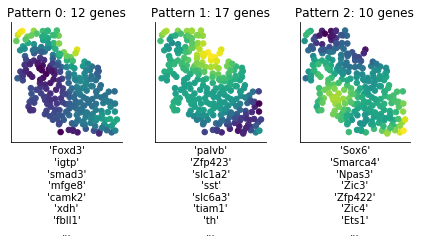

In [63]:
figsize(10, 3.5)
for i, Ci in enumerate(histology_results.sort_values('pattern').pattern.unique()):
    C = patterns[Ci]
    plt.subplot(1, K_hat, i + 1)
    plt.scatter(X[:,0], -X[:,1], c=C, s=30, rasterized=True)
    plt.axis('equal')
    plt.title('Pattern {}: {} genes'.format(Ci, histology_results.query('pattern == @Ci').shape[0] ))
    
    xlab = '\n'.join(histology_results.query('pattern == @Ci').sort_values('membership')['g'].tolist()[:7])
    plt.xlabel(xlab + '\n...')
    
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()


This figure is the figure 2, h of the article. The patterns are not exactly similar, maybe other parameters have been used, like the lengthscale `l`

It is usually interesting to see what the coexpressed genes determining a histological pattern are:

In [62]:
for i in histology_results.sort_values('pattern').pattern.unique():
    
    print('Pattern {}'.format(i))
    print(', '.join(histology_results.query('pattern == @i').sort_values('membership')['g'].tolist()))
    print()

Pattern 0
'Foxd3', 'igtp', 'smad3', 'mfge8', 'camk2', 'xdh', 'fbll1', 'slc17a7', 'lyve', 'mog', 'myl14', 'ndnf'

Pattern 1
'palvb', 'Zfp423', 'slc1a2', 'sst', 'slc6a3', 'tiam1', 'th', 'htr3a', 'slc17a8', 'pdgfra', 'ngef', 'sncg', 'gad1', 'ctss', 'foxj1', 'slc5a7', 'opalin'

Pattern 2
'Sox6', 'Smarca4', 'Npas3', 'Zic3', 'Zfp422', 'Zic4', 'Ets1', 'Nr3c2', 'Foxo1', 'Maml3'



## II Data clustering on spatially informative genes

Now we can try to infer the positions of cells by taken informative gene from the spatial analysis. It could help us to infer a relative map for single cell data that can't give spatial information, like RNAseq.

We use the processed data.

### 1) Gene Selection

We use the genes that are "spatially relevant" (with qval < 0.05). We used the data processed for SpatialDE

In [345]:
sres = results.query('qval < 0.05 & g != "log_total_count"').copy()



spatial_genes=res[sres['g'].tolist() ]

print(spatial_genes)


0      'Npas3'    'Zic3'     'sst'    'gad1'    'Ets1'  'Zfp422'   'Foxd3'  \
1382 -4.095484 -4.748369 -1.607860 -3.907655 -5.129344 -3.898397 -4.150883   
1383 -4.252334 -4.618060 -3.559328 -5.064819 -6.428469 -4.207327 -3.622395   
1384 -4.544698 -5.062974 -4.283551 -4.299258 -4.881789 -4.013319 -3.766964   
1385 -3.846366 -5.090062 -4.912123 -4.694504 -6.126135 -4.338327 -4.154138   
1386 -5.149966 -4.971877 -4.121698 -4.564722 -5.404759 -3.431706 -4.077625   
...        ...       ...       ...       ...       ...       ...       ...   
1634 -5.046274 -3.845643 -4.435928 -4.470432 -5.436137 -5.003650 -5.476437   
1635 -3.544329 -4.569707 -4.328172 -5.185410 -4.946444 -4.928049 -3.541788   
1636 -3.951028 -5.156496 -3.460008 -4.825775 -5.024024 -4.482173 -3.926528   
1637 -3.686964 -5.654371 -4.521367 -4.932534 -4.700160 -4.760965 -4.232283   
1638 -4.237339 -4.749804 -2.274457 -4.280374 -3.784480 -5.083974 -3.675596   

0       'Zic4'     'xdh'   'mfge8'  ...   'camk2'    'ngef'  's

### 2) Comparing different clustering algorithms

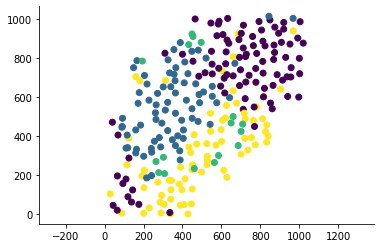

In [346]:
kmeans_labels = cluster.KMeans(n_clusters=4).fit_predict(spatial_genes)


figsize(6, 4)
plt.scatter(sample_info['x'], sample_info['y'], c=kmeans_labels);
plt.axis('equal'); 

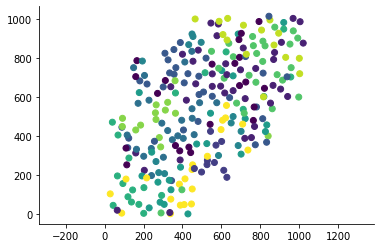

In [350]:
kmeans_labels = cluster.KMeans(n_clusters=12).fit_predict(spatial_genes)

figsize(6, 4)
plt.scatter(sample_info['x'], sample_info['y'], c=kmeans_labels);
plt.axis('equal'); 

In [332]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

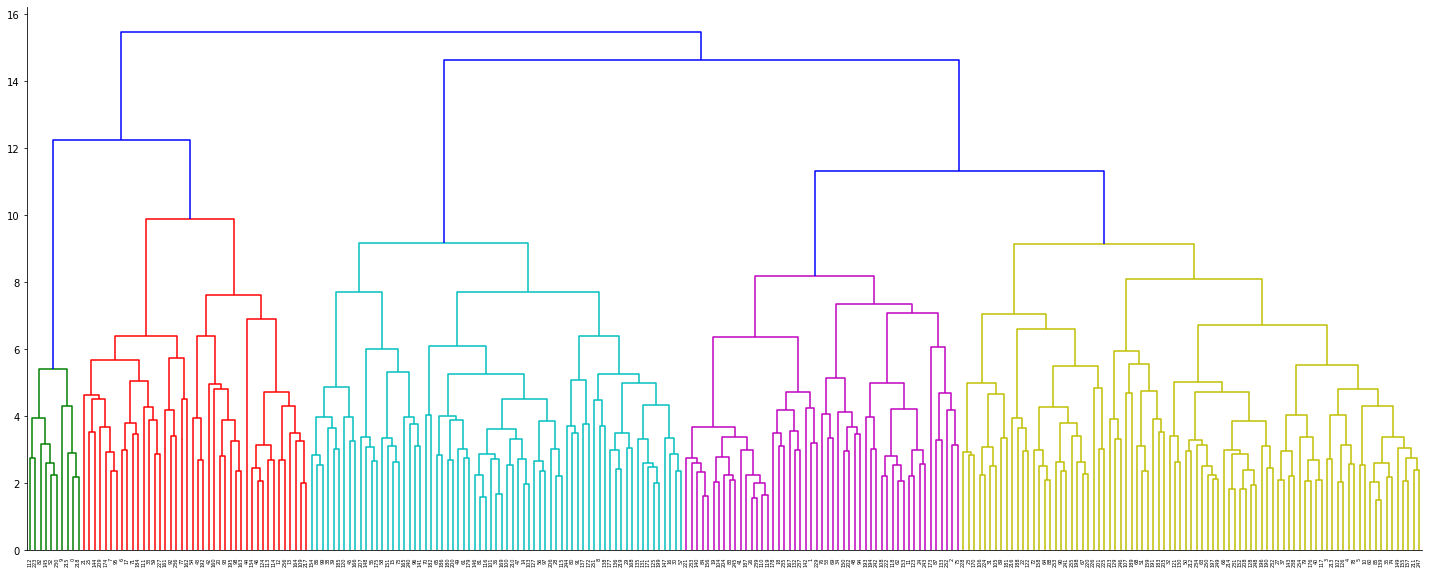

In [351]:
Z = linkage(spatial_genes, 'ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

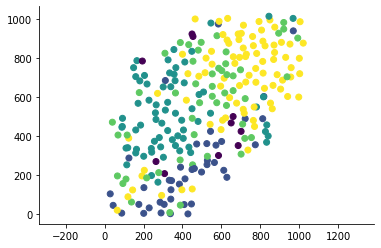

In [355]:
linkage_clusters=fcluster(Z, 10, criterion='distance')
len(linkage_clusters)

figsize(6, 4)
plt.scatter(sample_info['x'], sample_info['y'], c=linkage_clusters);
plt.axis('equal'); 

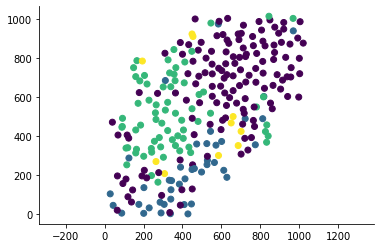

In [354]:
from sklearn.cluster import Birch

brc = Birch(n_clusters=4)
brc.fit(spatial_genes)

birch_clusters=brc.predict(spatial_genes)

figsize(6, 4)
plt.scatter(sample_info['x'], sample_info['y'], c=birch_clusters);
plt.axis('equal'); 

To conclude, the spatial genes can give broad information on cell positions. K-means algorithm seems to better catch these information.
Now we can ask can we have more precise information for every cells. For this, we will compare data reduction from spatial genes and real spatial position of the cells.

### 2) Using dimensionnality reduction

Now, let's imagine we don't have the spatial information, can we take a data reduction of the spation gene and find how cells are distributed in space.

In [247]:
tsne = TSNE(verbose=2,n_components=2);
YY = tsne.fit_transform(pattern_0);


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 257 samples in 0.012s...
[t-SNE] Computed neighbors for 257 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 257 / 257
[t-SNE] Mean sigma: 0.535878
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 64.6324539, gradient norm = 0.5037866 (50 iterations in 0.078s)
[t-SNE] Iteration 100: error = 63.2966194, gradient norm = 0.5552421 (50 iterations in 0.078s)
[t-SNE] Iteration 150: error = 63.2038651, gradient norm = 0.5403978 (50 iterations in 0.064s)
[t-SNE] Iteration 200: error = 65.7528763, gradient norm = 0.4932188 (50 iterations in 0.078s)
[t-SNE] Iteration 250: error = 66.8083191, gradient norm = 0.4866376 (50 iterations in 0.078s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.808319
[t-SNE] Iteration 300: error = 0.9981545, gradient norm = 0.0043830 (50 iterations in 0.062s)
[t-SNE] Iteration 350: error = 0.9423593, gradient norm = 0.0011754 (

To compare both distributions we need an indicator, we will use K-mean clustering by only taking the position of the cells.

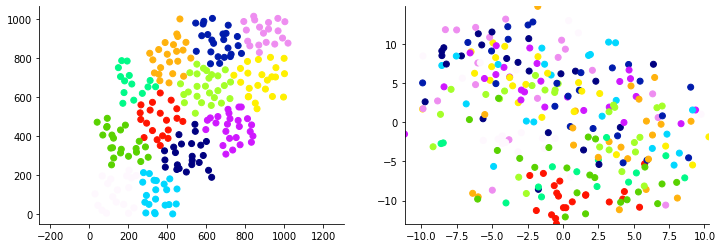

In [248]:
real_spatial_information=sample_info[['x','y']]

kmeans_labels = cluster.KMeans(n_clusters=12).fit_predict(real_spatial_information)

my_cmap = matplotlib.cm.get_cmap('gist_ncar')

f, (ax1, ax2) = plt.subplots(1, 2)


ax1.scatter(sample_info['x'], sample_info['y'], c=kmeans_labels, cmap=my_cmap);
ax1.set_title=("real spatial information")
ax1.axis('equal'); 

ax2.scatter(YY.T.tolist()[0], YY.T.tolist()[1], c=kmeans_labels, cmap=my_cmap);
ax2.axis([min(YY.T.tolist()[0]), max(YY.T.tolist()[0]), min(YY.T.tolist()[1]), max(YY.T.tolist()[1])]); 


In [249]:
import umap

standard_embedding = umap.UMAP(random_state=42).fit_transform(pattern_0)


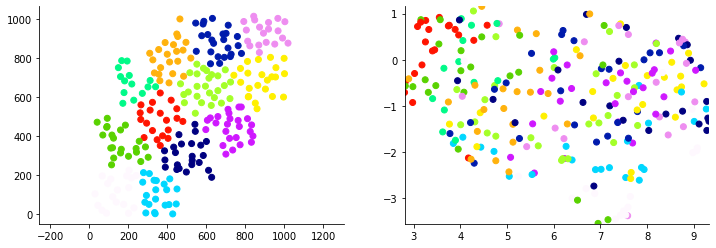

In [250]:
my_cmap = matplotlib.cm.get_cmap('gist_ncar')

f, (ax1, ax2) = plt.subplots(1, 2)


ax1.scatter(sample_info['x'], sample_info['y'], c=kmeans_labels, cmap=my_cmap);
ax1.set_title=("real spatial information")
ax1.axis('equal'); 

ax2.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans_labels, cmap=my_cmap);
ax2.axis([min(standard_embedding[:, 0]), max(standard_embedding[:, 0]), min(standard_embedding[:, 1]), max(standard_embedding[:, 1])]); 



In [265]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
pca_spatial=pca.fit(spatial_genes)

pca_spatial_genes=pca.transform(spatial_genes)


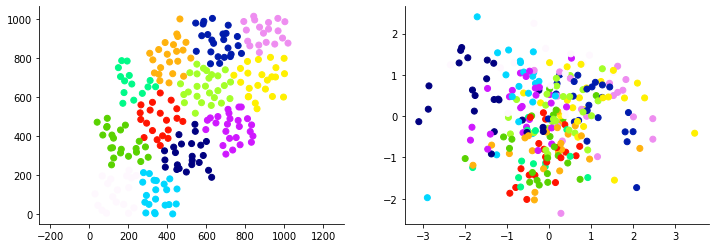

In [264]:
my_cmap = matplotlib.cm.get_cmap('gist_ncar')

f, (ax1, ax2) = plt.subplots(1, 2)


ax1.scatter(sample_info['x'], sample_info['y'], c=kmeans_labels, cmap=my_cmap);
ax1.set_title=("real spatial information")
ax1.axis('equal'); 

ax2.scatter(pca_spatial_genes.T.tolist()[0], pca_spatial_genes.T.tolist()[1], c=kmeans_labels, cmap=my_cmap);



For these three plots, some close a lot of nearby cells in the space are not close in spatial genes. All of these data reduction algorithms processing the spatial genes can't gives back the spatial information.
We can conclude that there is a loss of the space position data if we only take the spatial genes infered by the SpatialDE algorithm.

A critical is that the spatial genes may not delimit teritories but most of them will have more complicate patterns. Trying to have the global information may not be a good idea. Instead, we should more focus on how spatial genes influence these spatial patterns.

The processed data is different than usualy processings, investigating in this process may change the current results.

## Conclusion

We can recover broad spatial domains with clustering algorithms like k-means. However the results are not so good and we can't infer the relative cell position only from spatial genes. 
We also have not to forget that these "spatial genes" may be characterized as spatial only in some context. With differents genomes and epigenetic state that can vary in cancer, the spatial genes may change. 
Something to do would be to check if the spatial genes are always the same.
We can also check what are the functions of these genes and are they mechanically linked.